In [1]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [2]:
# review_train = pd.read_csv('../data/reviews_train.csv', encoding='utf-8')
review_train = pd.read_csv('../data/kinopoisk_train.csv', encoding='utf-8')

In [3]:
review_train.head()

,text,label
0,"\n Прежде чем вообще что-то говорить, нуж...",1
1,"\nНа мой взгляд, любой боевик должен быть стил...",1
2,\nОб этом фильме мне довелось слышать не один ...,1
3,"\nОчень сложно вспомнить фильм, в котором не б...",0
4,\nВ фильме показан нетрадиционный Шерлок Холмс...,1


In [4]:
texts, labels = review_train.text.values, review_train.label.values

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', SGDClassifier())
    ])
cv_res = cross_val_score(pipeline, texts, labels, scoring='f1_macro', cv=10, verbose=1, n_jobs=-1)
print cv_res.mean(), cv_res.std()

0.541235695587 0.00372515238749


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished


In [6]:
cv_res = cross_val_score(pipeline, texts, labels, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
print cv_res.mean(), cv_res.std()

0.824494207331 0.00311774723948


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.3s finished


### Reading vocabulary and embeddings

In [5]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [6]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Яa-zA-Z]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

Заказывал принтер сетевой по безналичной оплате с доставкой в Самару. Доставили через 4 дня после оплаты. Всем доволен.
Заказывал принтер сетевой по безналичной оплате с доставкой в Самару Доставили через дня после оплаты Всем доволен
заказывать принтер сетевой по безналичный оплата с доставка в самар доставить через день после оплата весь довольный
[5814, 9452, 6700, 17, 30383, 2409, 8, 5692, 2, 7312, 4145, 183, 132, 117, 2409, 11, 2123, 0]


Dumping

Loading

In [8]:
X = cPickle.load(open('../data/X_review_train.pkl', 'rb'))

Distribution of sequences' lengths 

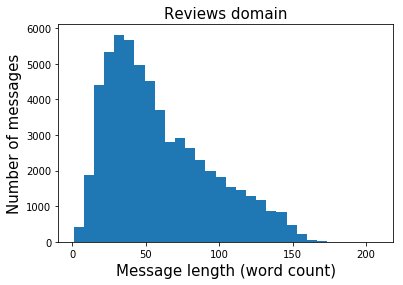

In [9]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=30)
plt.title("Reviews domain", fontsize=15)
plt.xlabel("Message length (word count)", fontsize=15)
plt.ylabel("Number of messages", fontsize=15)
plt.show()

Drop samples with the length > 150

In [10]:
length_max = 150
y = review_train.label.values
y = y[np.array(map(len, X)) <= length_max]
X = [x for x in X if len(x) <= length_max]

### Zero padding

In [11]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [12]:
for x in X[:3]:
    print x

[65, 869, 43, 2135, 37924, 2799, 11, 1100, 802, 342, 1, 514, 373, 2, 2293, 127, 43, 10, 53, 151, 8, 4434, 7611, 78, 32611, 1038, 9653, 5, 29, 869, 2, 413, 582, 9, 1475, 2, 460, 1270, 1, 10, 7611, 827, 14, 2197, 8122, 11, 1475, 241, 9626, 59, 756, 1, 11, 67, 394, 1270, 704, 703, 5, 162, 35, 1, 48, 35, 96, 151, 133, 9, 57, 382, 9, 3, 637, 68, 194, 1270, 12, 4, 137, 221, 9, 291, 11898, 22, 2, 2332, 115, 43011, 7, 78, 5763, 1, 25, 1131, 1, 2729, 449, 489, 162, 1270, 48, 57, 194, 263, 3205, 5, 29, 869, 103, 48, 11, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 7, 869, 15574, 217, 222, 901, 3705, 78611, 206, 197, 6, 2, 413, 645, 15, 206, 429, 197, 222, 5, 62, 21530, 2795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Split into train and validation sets

In [13]:
X = np.array(X)

In [14]:
def cls2probs(cls):
    if cls == -1:
        return [1.,0.]
    else:
        return [0.,1.]
y = np.array([cls2probs(cls) for cls in y])

In [15]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=40)

In [16]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[10840, 42049]
Validation class frequencies:	[1209, 4668]
Constant classifier's validation accuracy:	0.794282797346


### Resampling

# Network learning

In [23]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from utils import batch_generator

In [18]:
from sklearn.metrics import f1_score
f_macro = lambda y1, y2: f1_score(y1, y2, average="macro")
f_micro = lambda y1, y2: f1_score(y1, y2, average="micro")

y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,1] = 1.
print "Constant classifier's macro-averaged F-score on validation set:", f_macro(y_val, y_pred_major)
print "Constant classifier's micro-averaged F-score on validation set:", f_micro(y_val, y_pred_major)

Constant classifier's macro-averaged F-score on validation set: 0.442674253201
Constant classifier's micro-averaged F-score on validation set: 0.794282797346


/home/ilivans/.virtualenvs/cmn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### CNN

In [26]:
EMBED_DIM = 300
HIDDEN_SIZE = 300
NUM_CLASSES = 2
filter_sizes = [3, 4]
num_filters = 300
sequence_length = length_max

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, None])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)
batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
batch_embedded_expanded = tf.expand_dims(batch_embedded, -1)
    
# Create a convolution + maxpool layer for each filter size
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    # Convolution Layer
    filter_shape = [filter_size, EMBED_DIM, 1, num_filters]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[num_filters]))
    conv = tf.nn.conv2d(
        batch_embedded_expanded,
        W,
        strides=[1, 1, 1, 1],
        padding="VALID")
    # Apply nonlinearity
    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
    # Maxpooling over the outputs
    pooled = tf.nn.max_pool(
        h,
        ksize=[1, sequence_length - filter_size + 1, 1, 1],
        strides=[1, 1, 1, 1],
        padding='VALID')
    pooled_outputs.append(pooled)

# Combine all the pooled features
num_filters_total = num_filters * len(filter_sizes)
h_pool = tf.concat(pooled_outputs, 3)
output = tf.reshape(h_pool, [-1, num_filters_total])

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [27]:
# Adam parameters
LEARNING_RATE = 1e-3
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=target_ph),
                               name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 9
	 Train loss: 0.028	 ce: 0.028	 acc: 0.992	 f_macro: 0.989
	 Valid loss: 0.318	 ce: 0.318	 acc: 0.890	 f_macro: 0.821


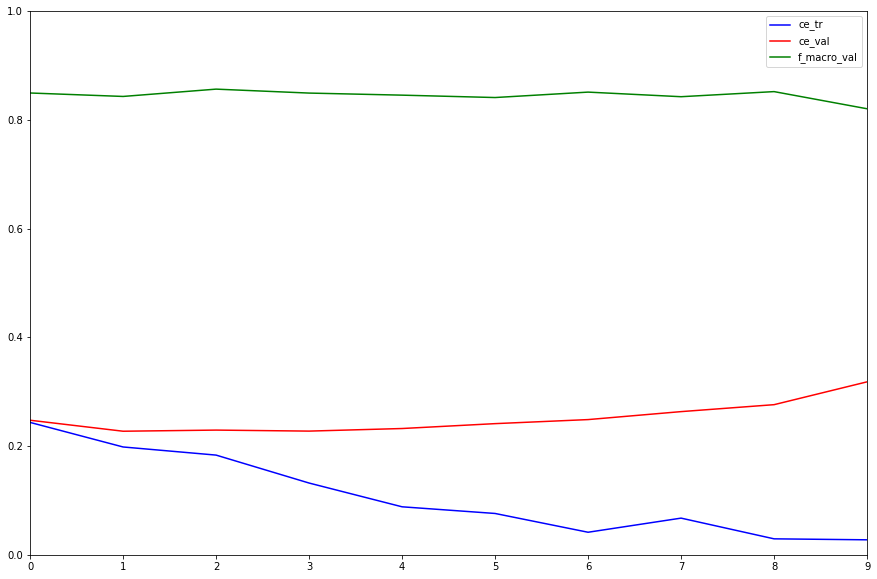

CPU times: user 15min 33s, sys: 3min 15s, total: 18min 48s
Wall time: 21min 47s


In [24]:
%%time
from sklearn.model_selection import StratifiedKFold, KFold

FOLDS = 10

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 10


skf = KFold(FOLDS, shuffle=True, random_state=42)

results = []

for train_index, test_index in skf.split(X, y):
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            
            y_pred_val, ce_val, loss_val, acc_val = [], 0, 0, 0
            num_val_batches = X_val.shape[0] / BATCH_SIZE
            for i in range(num_val_batches):
                x_batch_val, y_batch_val = X_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE],\
                                           y_val[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
                seq_len_val = np.array([list(x).index(eos_id) + 1 for x in x_batch_val])
                y_pred_val_, ce_val_, loss_val_, acc_val_ = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: x_batch_val, target_ph: y_batch_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})
                y_pred_val += list(y_pred_val_)
                ce_val += ce_val_
                loss_val += loss_val_
                acc_val += acc_val_
            
            y_pred_val = np.array(y_pred_val)
            ce_val /= num_val_batches
            loss_val /= num_val_batches
            acc_val /= num_val_batches

            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val),\
                                       f_micro(y_val[:num_val_batches * BATCH_SIZE], y_pred_val)
        

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results.append([max(acc_val_l), max(f_macro_val_l)])

In [25]:
# hid 300, ep 10, Adam 1e-3, max_val_f
results

[[0.90536221590909094, 0.86204278884069963],
 [0.90234375, 0.85367918253824304],
 [0.89701704545454541, 0.84285550523096697],
 [0.90287642045454541, 0.85261131486448871],
 [0.89524147727272729, 0.84816582444319666],
 [0.90056818181818177, 0.85228249474123574],
 [0.90074573863636365, 0.85866966360127295],
 [0.90269886363636365, 0.85747561036658804],
 [0.90607244318181823, 0.85701071648845861],
 [0.90092329545454541, 0.85664716343793257]]

---

---

---

# Testing

In [7]:
review_test = pd.read_csv('../data/reviews_test.csv', sep=',', encoding='utf-8')
texts_test, labels_test = review_test.text.values, review_test.label.values

In [8]:
from sklearn.metrics import accuracy_score, f1_score

pipeline.fit(texts, labels)
pred = pipeline.predict(texts_test)
print f1_score(pred, labels_test, average='macro')
print accuracy_score(pred, labels_test)

0.375979044646
0.81020021645


/home/ilivans/.virtualenvs/cmn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [263]:
%%time
pool = multiprocessing.Pool()
X_test = pool.map(text2seq, texts_test)
cPickle.dump(X_test, open('../data/X_review_test.pkl', 'wb'))

CPU times: user 272 ms, sys: 728 ms, total: 1 s
Wall time: 39 s


In [254]:
X_test = cPickle.load(open('../data/X_review_test.pkl', 'rb'))

In [274]:
X_test = [x + [eos_id]*(length_max - len(x)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [292]:
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((537, 29), (537, 3), (3418, 29), (3418, 3))

In [352]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_birnn_momentum.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in X_test])
    y_pred_test, ce_test, loss_test, acc_test = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: X_test, target_ph: y_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
    seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
    y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})

In [353]:
y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)
print f_macro_val, f_micro_val

0.629508196721 0.794366197183


In [354]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test, f_micro_test = f_macro(y_test, y_pred_test), f_micro(y_test, y_pred_test)
print f_macro_test, f_micro_test

0.434433507829 0.522274881517
